# Anomaly Detection in Practice

In [*Part 1*]() and [*Part 2*]() of this series we developed a technique for detecting anomalies in time-series data. In this part we will apply the technique to a scenario we might encounter in actual water tank data. The two most important anomalies to detect in water tank monitoring are: tank volume below normal levels and tank levels to high (possibly causing overflow). In this part, I will simulate a low-water condition and test the model with the simulated data.

In [1]:
# load libraries and set plot parameters
import numpy as np
from scipy.signal import savgol_filter

from anomaly_utils import segment, plot_segments, window_segments, cluster, reconstruct

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

"Train" our model to get our collection of centroids:

In [2]:
data = open('watertank_data.csv').readlines()
points = [float(p.strip()) for p in data]
all_data = np.array(points)
half = int(len(points)/2)
train = all_data[1200:half]
train -= np.amin(train) + (np.amax(train) - np.amin(train))/2
smoothed_train = savgol_filter(train, 51, 2)

segment_length = 90
step_size = 9
num_clusters = 40

# segment the data
segments = segment(smoothed_train, segment_length, step_size)

# apply window function to all segments
windowed_segments = window_segments(segments, segment_length)

# cluster the segments
clusterer = cluster(windowed_segments, num_clusters)

Now let's simulate a water tank falling below the normal lower limit:

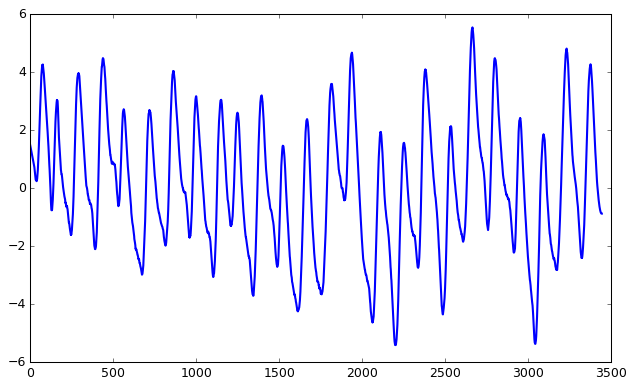

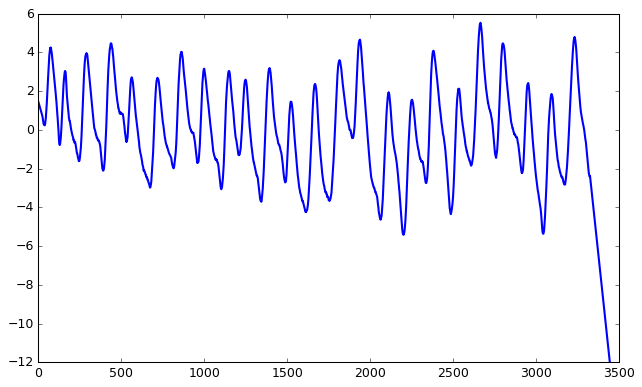

In [3]:
test = all_data[1200:half]
test -= np.amin(train) + (np.amax(train) - np.amin(train))/2
smoothed_test = savgol_filter(test, 51, 2)
plt.plot(smoothed_test)
plt.show()
# force the last 120 readings to simulate water levels below normal
ramp = np.linspace(smoothed_test[-120], -12, 120)
smoothed_test[-120:] = ramp
plt.plot(smoothed_test)

Apply our anomaly detection technique:

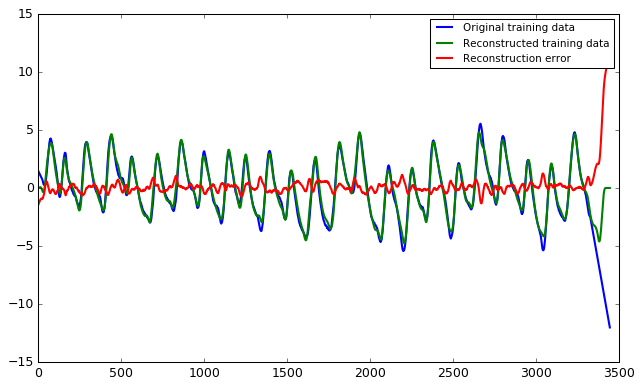

In [4]:
# reconstruct the training time-series
reconstructed_data = reconstruct(smoothed_test, segment_length, clusterer)
error = reconstructed_data - smoothed_test

# plot the results
plt.plot(smoothed_test, label="Original training data")
plt.plot(reconstructed_data, label="Reconstructed training data")
plt.plot(error, label="Reconstruction error")
plt.legend()
plt.show()

### Refining model selection
This technique certainly does detect the low water level condition, but the model used here is based on one used to detect anomalies in EKG readings. EKG readings are inherently zero-based, unlike our water tank readings. Also, in EKG data, you care about the time dynamics of the signal. In the case of water tank monitoring, we care more about the tank becoming too full or too empty, and we don't really care about the temporal qualities of the data (although in a later section we may revisit this question). In the [*next section*](https://github.com/mclarknc/Anomaly-Detection/blob/master/Anomaly%20Detection%20-%20Histogram%20Model.ipynb), we will develop an alternative clustering model based on a histogram of our tank data.